# jaxsp Tutorial

In [1]:
import jax
jax.config.update("jax_enable_x64", True)

import numpy as np
import jax.numpy as jnp

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.size'] = 10
mpl.rcParams['axes.grid'] = True
mpl.rcParams['axes.xmargin'] = 0
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['legend.frameon'] = False
mpl.rcParams['savefig.bbox'] = 'tight'

In [3]:
import jaxsp as jsp

jaxsp uses the unit convention used in [Schive2014](https://arxiv.org/abs/1406.6586).
Concordance parameters are chosen as in [gravsphere](https://github.com/justinread/gravsphere), see `constants.py` and `units.py`for exact defintions. 

In [4]:
m22 = 2.0
u = jsp.set_schroedinger_units(m22)

### Input Density Profiles

In [5]:
rho = jax.vmap(jsp.rho, in_axes=(0,None))

In [6]:
cNFWtides_params = jnp.array([
    357964808.148399 * u.from_Msun, 
    25.690207, 
    0.407461, 
    0.012670 * u.from_Kpc, 
    1.857991 * u.from_Kpc, 
    3.729259
])
density_params = jsp.init_core_NFW_tides_params_from_sample(cNFWtides_params)
r99 = jsp.enclosing_radius(0.99, density_params)
density_params

core_NFW_tides_params:
	name=419408337316433410,
	M200=3164.43059968201,
	c=25.690207,
	n=0.407461,
	rc=0.0008429901872099406,
	rt=0.12362021948890171,
	delta=3.729259,
    Derived:
	rs=0.0379326701578606,
	g=0.4307070628318999,
	rho0=1987135.4034031027,

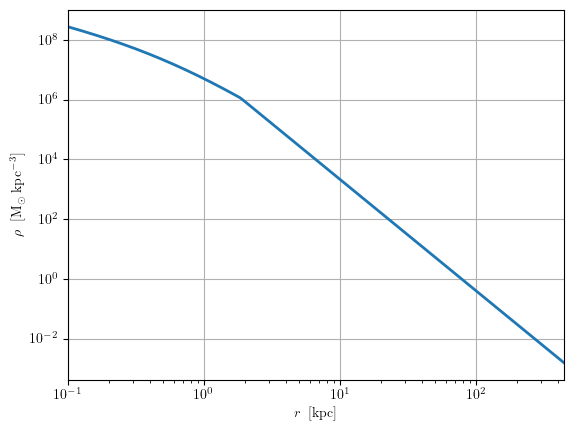

In [7]:
fig, ax = plt.subplots()
ax.set_xscale("log")
ax.set_yscale("log")
r = jnp.logspace(jnp.log10(100 * u.from_pc), jnp.log10(r99), 200)
ax.plot(r * u.to_Kpc, rho(r, density_params) * u.to_Msun/u.to_Kpc**3)
ax.set_ylabel(r"$\rho \;\;\mathrm{[M_\odot\;kpc^{-3}]}$")
ax.set_xlabel(r"$r \;\;\mathrm{[kpc]}$")
plt.show()

### Gravitational Potential

In [8]:
potential = jax.vmap(jsp.potential, in_axes=(0,None))

In [9]:
rmin = .1 * u.from_pc
rmax = jsp.enclosing_radius(0.999, density_params)
N = 512
potential_params = jsp.init_potential_params(density_params, rmin, rmax, N) 
potential_params

potential_params:
	name=326040455059355710,
	density_params=419408337316433410,
	N=512,
	rmin=6.653434784608841e-06,
	rmax=680.9150123152699,

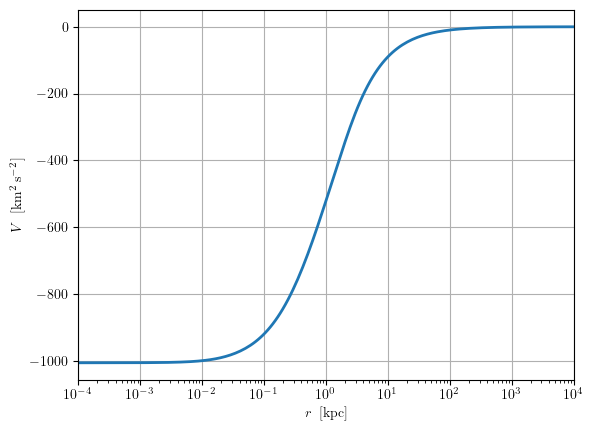

In [10]:
fig, ax = plt.subplots()
ax.set_xscale("log")
r = jnp.logspace(jnp.log10(rmin), jnp.log10(rmax), 200)
ax.plot(r * u.to_Kpc, potential(r, potential_params) * u.to_kms**2)
ax.set_ylabel(r"$V \;\;\mathrm{[km^2 \;s^{-2}]}$")
ax.set_xlabel(r"$r \;\;\mathrm{[kpc]}$")
plt.show()

### Eigenstate Library

In [11]:
eval_library = jax.vmap(jax.vmap(jsp.eval_radial_eigenmode, in_axes=(None, 0)), in_axes=(0,None))

In [13]:
rmin = .1 * u.from_pc
rmax = jsp.enclosing_radius(0.99, density_params)
N = 1024
a = 1
b = 10
eigenstate_lib = jsp.init_eigenstate_library(potential_params, rmin, rmax, a, b, N)
eigenstate_lib

eigenstate_library:
	name=852065223366093480,
	potential_params=326040455059355710,
	total number of modes=1150,
	lmax=47,
	nmax=44,
	Emin=-1134.8559103361958,
	Emax=-5.467610653870452

In [13]:
from typing import NamedTuple

def tupleware(obj):
    if isinstance(obj, dict):
        fields = sorted(obj.keys())
        namedtuple_type = NamedTuple(
            typename='TWare',
            field_names=fields,
            rename=True,
        )
        field_value_pairs = OrderedDict(
            (str(field), tupleware(obj[field])) for field in fields)
        try:
            return namedtuple_type(**field_value_pairs)
        except TypeError:
            # Cannot create namedtuple instance so fallback to dict (invalid attribute names)
            return dict(**field_value_pairs)
    elif isinstance(obj, (list, set, tuple, frozenset)):
        return [tupleware(item) for item in obj]
    else:
        return obj

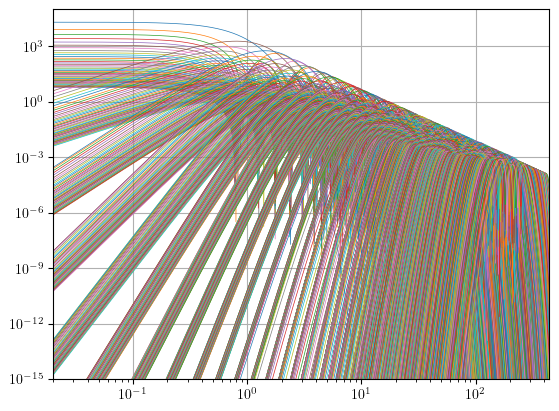

In [14]:
fig, ax = plt.subplots()
ax.set_xscale("log")
ax.set_yscale("log")
r = jnp.logspace(jnp.log10(20 * u.from_pc), jnp.log10(rmax), 1000)
R_j_r = eval_library(r, eigenstate_lib.radial_eigenmode_params)
ax.plot(r * u.to_Kpc, R_j_r**2, lw=0.5)
ax.set_ylim([1e-15, 1e5])
plt.show()

### Fitting Eigen State Coefficients 

In [15]:
rho_psi = jax.vmap(jsp.rho_psi, in_axes=(0,None,None))

In [17]:
tol = 1e-7
rmin = 20 * u.from_pc
rmax = jsp.enclosing_radius(0.99, density_params)
wavefunction_params = jsp.init_wavefunction_params(eigenstate_lib, density_params, rmin, rmax, tol)
wavefunction_params

wavefunction_params:
	name=124510867608694139,
	eigenstate_library=852065223366093480,
	density_params=419408337316433410,
	aj_2=[3.1204399508220587e-12, 0.32421175375166855],
	total_mass=2026.3301235096874,
	r_min=0.001330686956921769,
	r_max=29.33866439394716,
	distance=0.006501497387614624,

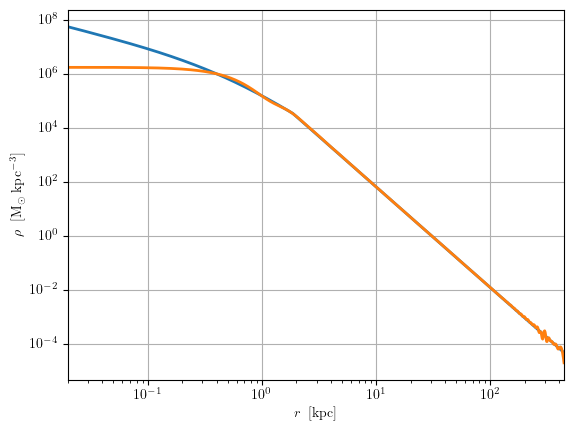

In [19]:
fig, ax = plt.subplots()
ax.set_xscale("log")
ax.set_yscale("log")

r = jnp.logspace(jnp.log10(rmin), jnp.log10(rmax), 1000)
ax.plot(r * u.to_Kpc, rho(r, density_params))
ax.plot(r * u.to_Kpc, rho_psi(r, wavefunction_params, eigenstate_lib))
ax.set_ylabel(r"$\rho \;\;\mathrm{[M_\odot\;kpc^{-3}]}$")
ax.set_xlabel(r"$r \;\;\mathrm{[kpc]}$")
plt.show()

### Volume Render (Experimental)

In [ ]:
!pip install yt

In [20]:
import yt
from yt.visualization.volume_rendering.api import (
    Scene, 
    Camera, 
    TransferFunctionHelper, 
    create_volume_source
)
from scipy.interpolate import NearestNDInterpolator
import s2fft

In [21]:
@jax.vmap
def rthetaphi_from(xyz):
    xy = xyz[0]**2 + xyz[1]**2
    r = jnp.sqrt(xy + xyz[2]**2)
    theta = jnp.arctan2(jnp.sqrt(xy), xyz[2]) 
    phi = jnp.arctan2(xyz[1], xyz[0])
    return jnp.array([r,theta,phi])

@jax.vmap
def xyz_from(rthetaphi):
    r, theta, phi = rthetaphi[0],rthetaphi[1],rthetaphi[2],
    x = r*jnp.cos(phi) * jnp.sin(theta)
    y = r*jnp.sin(phi) * jnp.sin(theta)
    z = r*jnp.cos(theta)
    return jnp.array([x,y,z])

def cartesian_product(*vecs):
    def cartesian_product(a, b):
        return jax.vmap(
            lambda a, b: jnp.c_[a * jnp.ones(b.shape[0]), b], in_axes=(0, None)
        )(a, b).reshape(-1, a.ndim + b.ndim)

    axb = cartesian_product(vecs[-2], vecs[-1])
    for vec in reversed(vecs[:-2]):
        axb = cartesian_product(vec, axb)
    return axb

In [71]:
N = 256
R = 0.98 * wavefunction_params.r_fit
dx = 2*R/N
print(dx)
x = y = z = dx * jnp.arange(N) + dx / 2 - R

def cartesian_product(*vecs):
    def cartesian_product(a, b):
        return jax.vmap(
            lambda a, b: jnp.c_[a * jnp.ones(b.shape[0]), b], in_axes=(0, None)
        )(a, b).reshape(-1, a.ndim + b.ndim)

    axb = cartesian_product(vecs[-2], vecs[-1])
    for vec in reversed(vecs[:-2]):
        axb = cartesian_product(vec, axb)
    return axb
xyz = cartesian_product(x,y,z)
rthetaphi = rthetaphi_from(xyz)

0.22462414926615792


In [85]:
L = (eigenstate_lib.radial_eigenmode_params.l[-1]+1).item()
nside = L//2
R = 0.98 * wavefunction_params.r_fit
r = jnp.linspace(wavefunction_params.r_min, R, 512)
theta = s2fft.sampling.s2_samples.thetas(L, sampling="healpix", nside=nside)
phi = [s2fft.sampling.s2_samples.phis_ring(t, nside) for t in range(theta.shape[0])]
phi_len = jnp.array([p.shape[0] for p in phi])
theta = jnp.repeat(theta, phi_len)
phi = jnp.concatenate(phi)
theta_phi = jnp.c_[theta, phi]
psi_new_batch = jax.jit(jax.vmap(jsp.psi, in_axes=(0,None,None,None,None,None)), static_argnums=(3,4))

psi2_healpix = jnp.abs(psi_new_batch(r, wavefunction_params, eigenstate_lib, 
                          eigenstate_lib.radial_eigenmode_params.l[-1].item(), 
                          jnp.max(eigenstate_lib.radial_eigenmode_params.n).item(),
                          jax.random.PRNGKey(42)))**2
xyz_exact = xyz_from(cartesian_product(r, theta_phi))
psi2_interp = NearestNDInterpolator(xyz_exact, psi2_healpix.flatten())

In [86]:
psi2_xyz = psi2_interp(xyz).reshape(N,N,N)

In [87]:
ds = yt.load_uniform_grid(
    dict(density=psi2_xyz * u.to_Msun/u.to_Kpc**3),
    [N,N,N],
    bbox=np.array([[-R, R], [-R, R], [-R, R]]) * u.to_Kpc,
    length_unit="kpc",
    mass_unit="Msun"
)

yt : [INFO     ] 2024-08-07 00:33:21,135 Parameters: current_time              = 0.0
yt : [INFO     ] 2024-08-07 00:33:21,136 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2024-08-07 00:33:21,136 Parameters: domain_left_edge          = [-432.1360626 -432.1360626 -432.1360626]
yt : [INFO     ] 2024-08-07 00:33:21,136 Parameters: domain_right_edge         = [432.1360626 432.1360626 432.1360626]
yt : [INFO     ] 2024-08-07 00:33:21,137 Parameters: cosmological_simulation   = 0


yt : [INFO     ] 2024-08-07 00:34:36,537 Rendering scene (Can take a while).
yt : [INFO     ] 2024-08-07 00:34:36,540 Creating volume


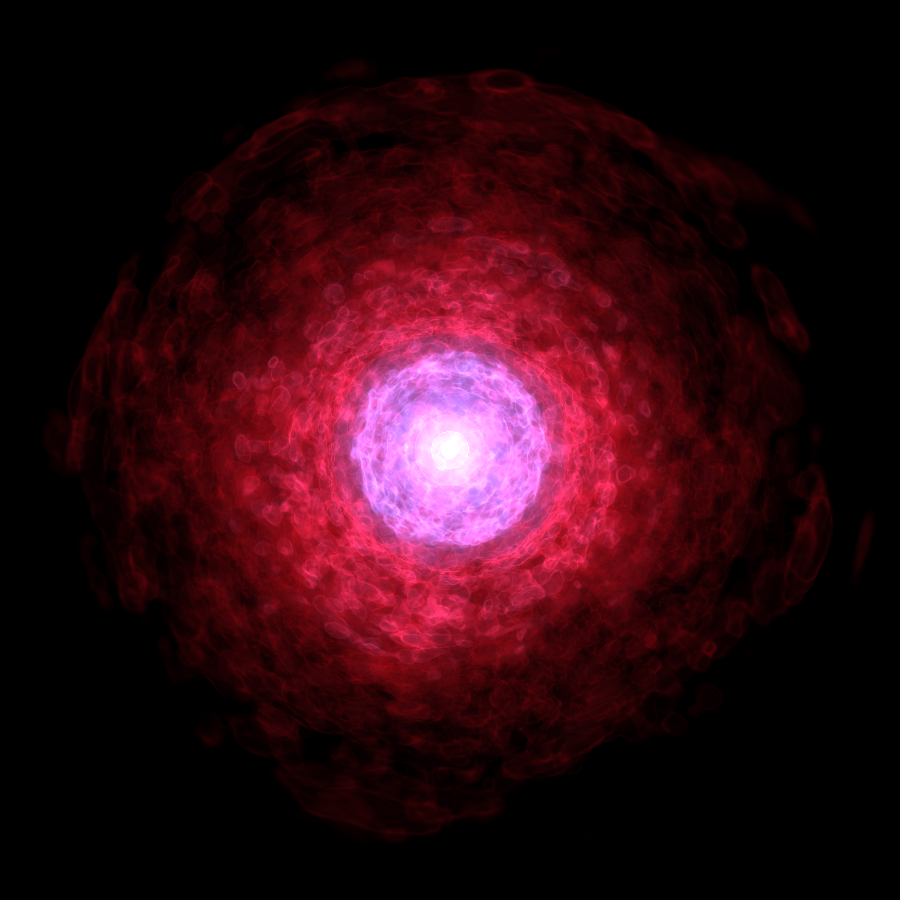

In [89]:
ds_section = ds.sphere(ds.domain_center,((R * u.to_Kpc).item(),"kpc"))
sc = yt.create_scene(ds_section, ("stream", "density"), "perspective")
source = sc.get_source()
source.set_log(True)
bounds=(1e-2, 3e5)
    
tf = yt.ColorTransferFunction(np.log10(bounds), grey_opacity=False)

def quadramp(vals, minval, maxval):
    return ((vals - vals.min()) / (vals.max() - vals.min()))**0.5

tf.map_to_colormap(
    np.log10(bounds[0]), np.log10(bounds[1]), 
    colormap="gist_stern", 
    scale_func=quadramp
)
tf.add_layers(8,
              colormap="gist_stern", 
              alpha=np.geomspace(1, 6, 8))

source.tfh.tf = tf
source.tfh.bounds = bounds

camera = sc.camera
camera.position = [1.,0,0]
camera.resolution = (900,900)
camera.zoom(1.)

camera.switch_orientation()
sc.show(sigma_clip=3.)